In [1]:
from omegaconf import OmegaConf
import numpy as np
import os
import re
import os.path as osp
import torch
import pytorch_lightning as pl
from tqdm import tqdm
from omegaconf import OmegaConf
import wandb
from pytorch_lightning.loggers import WandbLogger

import model_factory
from graph_data_module import GraphDataModule
from train import Runner
from datasets_torch_geometric.dataset_factory import create_dataset
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import torchvision
import torchmetrics
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
entity = "haraghi"
project = "DGCNN"

In [3]:
run_ids = ['9rrxu350','x4lf35wy']
# run_ids = ['2yqeh948']

artifact_dirs = [WandbLogger.download_artifact(artifact=f"{entity}/{project}/model-{run_id}:best") for run_id in run_ids]

wandb: Downloading large artifact model-2yqeh948:best, 244.96MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.9


In [4]:
api = wandb.Api()

In [6]:
cfg_bare = OmegaConf.load("config_bare.yaml")
configs = [api.run(osp.join(entity, project, run_id)).config for run_id in run_ids]
cfgs = [OmegaConf.merge(cfg_bare,OmegaConf.create(config)) for config in configs]
cfg_files = []
for cfg in cfgs:
    if "cfg_path" in cfg.keys():
        print(cfg.cfg_path)
        cfg_files.append(OmegaConf.merge(cfg_bare,OmegaConf.load(cfg.cfg_path)))
    else:
        cfg_files.append(cfg)
            
    
# cfg = OmegaConf.merge(cfg_file, cfg)
# print(OmegaConf.to_yaml(cfg))

cfg_folder/EST_NCALTECH101_20000.yaml


In [7]:
def recursive_dict_compare(all_cfg, other_cfg):
    """
    Recursively compare two dictionaries and return their differences.
    """

    
    # Initialize the result dictionary
    diff = {}

    # Check for keys in dict1 that are not in dict2
    for key in other_cfg:
        if key not in all_cfg:
            diff[key] = other_cfg[key]
        else:
            # If the values are dictionaries, recursively compare them
            if isinstance(all_cfg[key], dict) and isinstance(other_cfg[key], dict):
                nested_diff = recursive_dict_compare(all_cfg[key], other_cfg[key])
                if nested_diff:
                    diff[key] = nested_diff
            # Otherwise, compare the values directly
            elif all_cfg[key] != other_cfg[key]:
                if not(key == "num_classes" and other_cfg[key] is None and all_cfg[key] is not None):
                    diff[key] = other_cfg[key]
                    

    return diff


In [8]:
print([recursive_dict_compare(OmegaConf.to_object(cfg),OmegaConf.to_object(cfg_file)) for cfg, cfg_file in zip(cfgs, cfg_files)])

[{}]


In [9]:
# Seed everything. Note that this does not make training entirely
# deterministic.
for cfg in cfgs:
    pl.seed_everything(cfg.seed, workers=True)

for cfg in cfgs[1:]:
    compare_dict = recursive_dict_compare(OmegaConf.to_object(cfgs[0].dataset),OmegaConf.to_object(cfg.dataset))
    if len(compare_dict)!=0:
        if not (len(compare_dict) == 1 and 'num_workers' in compare_dict.keys()):
            print(compare_dict)
            print(cfg.dataset)
            print(cfgs[0].dataset)
            # raise Exception("Datasets are not the same")
# Create datasets using factory pattern


gdm = GraphDataModule(cfgs[0])
for cfg in cfgs:
    cfg.dataset.num_classes = gdm.num_classes

Global seed set to 0


In [10]:
def percentile(t, q):
    B, C, H, W = t.shape
    k = 1 + round(.01 * float(q) * (C * H * W - 1))
    result = t.view(B, -1).kthvalue(k).values
    return result[:,None,None,None]

def create_image(representation):
    B, C, H, W = representation.shape
    representation = representation.view(B, 3, C // 3, H, W).sum(2)

    # do robust min max norm
    representation = representation.detach().cpu()
    robust_max_vals = percentile(representation, 99)
    robust_min_vals = percentile(representation, 1)

    representation = (representation - robust_min_vals)/(robust_max_vals - robust_min_vals)
    representation = torch.clamp(255*representation, 0, 255).byte()

    representation = torchvision.utils.make_grid(representation)

    return representation

In [11]:
models = [model_factory.factory(cfg) for cfg in cfgs]

# Tie it all together with PyTorch Lightning: Runner contains the model,
# optimizer, loss function and metrics; Trainer executes the
# training/validation loops and model checkpointing.
 
runners = [Runner.load_from_checkpoint(osp.join(artifact_dir,"model.ckpt"), cfg=cfg, model=model) for artifact_dir, cfg, model in zip(artifact_dirs, cfgs, models)]

gdms = [GraphDataModule(cfg) for cfg in cfgs]
dss = []
for cfg,gdm in zip(cfgs, gdms):
    cfg.dataset.num_classes = gdm.num_classes

    dss.append(create_dataset(
        dataset_path = gdm.dataset_path,
        dataset_name  = gdm.dataset_name,
        dataset_type = 'test',
        transform = gdm.transform_dict['test'],
        num_workers=gdm.num_workers
    ))

In [12]:
class2ind = {c:[] for c in dss[0].categories}
for i,d in enumerate(dss[0]):
    
    class2ind[d.label[0]].append(i)

In [13]:
class2ind.keys()

dict_keys(['BACKGROUND_Google', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', '

In [14]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [15]:
class_name = 'speed_3'
idx = class2ind[class_name][torch.randint(0, len(class2ind[class_name]),(1,))]

SPARSE  = 0
DENSE = 1

TEST = SPARSE

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = runners[TEST].model.to(device)

target_layers = [model.classifier.layer4[-1]]
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model.classifier, target_layers=target_layers, use_cuda=True)

KeyError: 'speed_3'

In [18]:
dss[0][0]

Data(x=[20000, 1], pos=[20000, 3], file_id='image_0027.bin', label=[1], y=[1])

True label: 1 Predicted label: 0


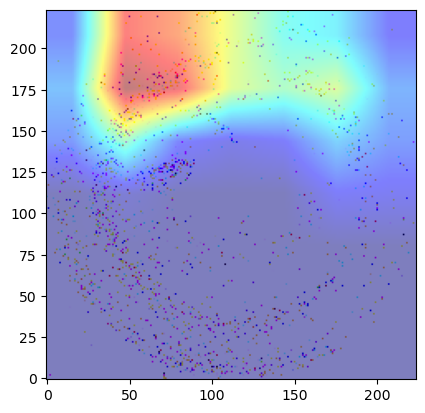

In [93]:
data = dss[TEST][idx]
data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
data = data.to(device)

targets = [ClassifierOutputTarget(data.y.item())]

vox = model.quantization_layer.forward(data)
vox_cropped = model.crop_and_resize_to_resolution(vox, model.crop_dimension).clone().detach()

out = model(data)
pred_label = torch.argmax(out, dim=1) 
print('True label:', data.y.item(), 'Predicted label:', pred_label.item())

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=vox_cropped, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

data_dense = dss[DENSE][idx]
data_dense.batch = torch.zeros(data_dense.num_nodes, dtype=torch.long)
data_dense = data_dense.to(device)

vox = model.quantization_layer.forward(data_dense)
vox_cropped = model.crop_and_resize_to_resolution(vox, model.crop_dimension)
rep = create_image(vox_cropped)

img = np.float32(rep.permute(1,2,0).detach().cpu().numpy())/255
target_size = (img.shape[1], img.shape[0])  # (H, W)
visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.gca().invert_yaxis()
plt.show()


In [57]:

torch.cuda.empty_cache()


model.eval()

correct = 0
total = 0

y=torch.tensor([],device=device)
y_hat=torch.tensor([],device=device)
preds = []
targets = []
files = []
with torch.no_grad():
    for data in tqdm(dss[SPARSE]):
        data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
        files.extend(data.file_id)
        targets.append(data.y)
        data = data.to(device)
        y = torch.cat((y,data.y))
        out = model(data)
        preds.append(out.clone().detach().cpu())
        label = torch.argmax(out, dim=1) 
        y_hat = torch.cat((y_hat,label))
        correct += torch.sum(label == data.y)
        total += data.y.shape[0]
  
y = y.clone().detach().cpu().numpy()
y_hat = y_hat.clone().detach().cpu().numpy() 
preds_ = torch.cat(preds,dim=0) #.permute(0,2,1)
targets_ = torch.cat(targets,dim=0)
metrics = torchmetrics.classification.Accuracy(num_classes=runners[0].cfg.dataset.num_classes, task="multiclass", top_k=1) 

acc = metrics(preds_, targets_).detach().cpu().numpy()
print(acc)
# return confusion_matrix_computed, y, y_hat, files

100%|██████████| 78/78 [00:01<00:00, 39.44it/s]

0.9230769


In [94]:
import wandb
api = wandb.Api()

# run is specified by <entity>/<project>/<run_id>
run = api.run(f"haraghi/DGCNN/{run_ids[0]}")

# save the metrics for the run to a csv file
metrics_dataframe = run.history()
metrics_dataframe.to_csv("_metrics.csv")

In [102]:
import wandb
api = wandb.Api()
# run is specified by <entity>/<project>/<run_id>
run = api.run(f"haraghi/DGCNN/{run_ids[0]}")
if run.state == "finished":
    for i, row in run.history().iterrows():
      print(row["_step"], row["val/acc_step"])

Index(['_step', 'epoch', 'test/acc', '_timestamp', 'train/loss_step',
       'trainer/global_step', 'lr-Adam', 'test/loss', 'val/acc_step',
       'val/loss_step', '_runtime', 'train/acc_step'],
      dtype='object')
Index(['_step', 'epoch', 'test/acc', '_timestamp', 'train/loss_step',
       'trainer/global_step', 'lr-Adam', 'test/loss', 'val/acc_step',
       'val/loss_step', '_runtime', 'train/acc_step'],
      dtype='object')
Index(['_step', 'epoch', 'test/acc', '_timestamp', 'train/loss_step',
       'trainer/global_step', 'lr-Adam', 'test/loss', 'val/acc_step',
       'val/loss_step', '_runtime', 'train/acc_step'],
      dtype='object')
Index(['_step', 'epoch', 'test/acc', '_timestamp', 'train/loss_step',
       'trainer/global_step', 'lr-Adam', 'test/loss', 'val/acc_step',
       'val/loss_step', '_runtime', 'train/acc_step'],
      dtype='object')
Index(['_step', 'epoch', 'test/acc', '_timestamp', 'train/loss_step',
       'trainer/global_step', 'lr-Adam', 'test/loss', 'val/acc

In [103]:
import wandb
api = wandb.Api()

# run = api.run("haraghi/DGCNN/<run_id>")
history = run.scan_history()
losses = [row["train/loss_step"] for row in history]

In [104]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("haraghi/DGCNN")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df.to_csv("project.csv")

[None,
 0.6954889297485352,
 None,
 None,
 0.6607316136360168,
 None,
 None,
 0.649823009967804,
 None,
 None,
 0.6450299620628357,
 None,
 None,
 0.6078656911849976,
 None,
 None,
 0.5718968510627747,
 None,
 None,
 0.6096546053886414,
 None,
 None,
 0.5579930543899536,
 None,
 None,
 0.5798433423042297,
 None,
 None,
 0.6057927012443542,
 None,
 None,
 0.535330593585968,
 None,
 None,
 0.5562747716903687,
 None,
 None,
 0.5141584277153015,
 None,
 None,
 0.5529287457466125,
 None,
 None,
 0.5300663113594055,
 None,
 None,
 0.5032094717025757,
 None,
 None,
 0.44882121682167053,
 None,
 None,
 0.5707560181617737,
 None,
 None,
 0.4941711723804474,
 None,
 None,
 0.48309096693992615,
 None,
 None,
 0.5172340273857117,
 None,
 None,
 0.5105404853820801,
 None,
 None,
 0.5038097500801086,
 None,
 None,
 0.44827723503112793,
 None,
 None,
 0.41754230856895447,
 None,
 0.477771133184433,
 None,
 None,
 0.4898321330547333,
 None,
 None,
 0.4984318017959595,
 None,
 None,
 0.5047857165336609

In [112]:



summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)



runs_df.to_csv("project.csv")

In [ ]:

configs = [api.run(osp.join(entity, project, run_id)).config for run_id in run_ids]
cfgs = [OmegaConf.merge(cfg_bare,OmegaConf.create(config)) for config in configs]
cfg_files = []
for cfg in cfgs:
    if "cfg_path" in cfg.keys():
        print(cfg.cfg_path)
        cfg_files.append(OmegaConf.merge(cfg_bare,OmegaConf.load(cfg.cfg_path)))
    else:
        cfg_files.append(cfg)
            

In [242]:
# Project is specified by <entity/project-name>
runs = api.runs("haraghi/DGCNN")
cfg_bare = OmegaConf.load("config_bare.yaml")
cfgs = [OmegaConf.merge(cfg_bare,OmegaConf.create(run.config)) for run in runs]
dataset_runs = {}
# Get the dataset names from the config file
dataset_names = list(set([cfg.dataset.name for cfg in cfgs]))
for dataset_name in dataset_names:
    # Get the runs for this dataset

    dataset_runs[dataset_name] = [(run,cfg) for run,cfg in zip(runs,cfgs) if 
                                  cfg.dataset.name == dataset_name and 
                                  cfg.model.name == 'EST' and 
                                  cfg.model.num_bins == 9 and
                                  cfg.model.resnet_pretrained and
                                  'test/acc' in run.summary and
                                  'epoch' in run.summary and
                                  (not cfg.model.cnn_type or cfg.model.cnn_type == "resnet34") and
                                  run.summary['epoch'] > 51 ]
    

    dataset_runs[dataset_name] = sorted(dataset_runs[dataset_name], key=lambda r: r[0].summary['test/acc'], reverse=True)
    print(dataset_name, len(dataset_runs[dataset_name]))
    # Get the run with the best validation accuracy
    # best_run = sorted(dataset_runs, key=lambda r: r.summary['val/acc_step'], reverse=True)[0]



NASL 24
FAN1VS3 11
NCALTECH101 9
NCARS 13


In [243]:
for run,cfg in dataset_runs['NCARS']:
    artifact_dirs = [WandbLogger.download_artifact(artifact=f"{entity}/{project}/model-{run_id}:best") for run_id in run_ids]
    print(run.summary['test/acc'], cfg.transform.train.num_events_per_sample)

0.9372603893280028 1024
0.923085868358612 2048
0.9212269186973572 None
0.9163471460342408 256
0.9162309765815736 10000
0.9157662391662598 None
0.911351203918457 4096
0.8985709547996521 None
0.8978738188743591 128
0.8662716150283813 64
0.8283954858779907 32
0.7920297384262085 16
0.7273149490356445 8
